# Loading FER Data-set

reference : 


1) https://appliedmachinelearning.blog/2018/11/28/demonstration-of-facial-emotion-recognition-on-real-time-video-using-cnn-python-keras/

2) https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data?select=example_submission.csv

In [1]:
#!pip install opencv-python
#!pip install keras

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [3]:
#!pip uninstall pandas

In [2]:
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
 
train_path = 'train.csv'
# test_path = '/content/gdrive/MyDrive/GraduationProject/Emotion_Classification/test.csv'

image_size=(48,48)

def load_fer2013():
    data = pd.read_csv(train_path)
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        #plt.imshow(face)
        #break
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = pd.get_dummies(data['emotion']).values
    return faces, emotions
 
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x
 
faces, emotions = load_fer2013()
faces = preprocess_input(faces)
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)

In [5]:
faces.shape

(28709, 48, 48, 1)

In [6]:
ytrain.shape

(22967, 7)

In [7]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import pandas as pd
import cv2
import numpy as np

# parameters
batch_size = 32
num_epochs = 10 #110
input_shape = (48, 48, 1)
verbose = 1
num_classes = 7
patience = 50
base_path = 'models_0_1/'
l2_regularization=0.01

# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
 
# model parameters
regularization = l2(l2_regularization)
 
# base
img_input = Input(input_shape)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
 
# module 1
residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 2
residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 3
residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 4
residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
x = Conv2D(num_classes, (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax',name='predictions')(x)
 
model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
 
# callbacks
log_file_path = base_path + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = base_path + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
#model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
model_checkpoint = ModelCheckpoint(model_names, 'val_accuracy', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

 
base_history = model.fit_generator(data_generator.flow(xtrain, ytrain,batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 46, 46, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 46, 46, 8)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

C:\Users\kheed\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
717/717 [==============================] - 251s 346ms/step - loss: 1.9025 - accuracy: 0.2844 - val_loss: 1.7092 - val_accuracy: 0.4000

Epoch 00001: val_accuracy improved from -inf to 0.40003, saving model to models_0_1\_mini_XCEPTION.01-0.40.hdf5
Epoch 2/10
717/717 [==============================] - 289s 403ms/step - loss: 1.5635 - accuracy: 0.4189 - val_loss: 1.4181 - val_accuracy: 0.4782

Epoch 00002: val_accuracy improved from 0.40003 to 0.47823, saving model to models_0_1\_mini_XCEPTION.02-0.48.hdf5
Epoch 3/10
717/717 [==============================] - 270s 376ms/step - loss: 1.4264 - accuracy: 0.4701 - val_loss: 1.4875 - val_accuracy: 0.4462

Epoch 00003: val_accuracy did not improve from 0.47823
Epoch 4/10
717/717 [==============================] - 267s 372ms/step - loss: 1.3669 - accuracy: 0.4858 - val_loss: 1.3342 - val_accuracy: 0.5049

Epoch 00004: val_accuracy improved from 0.47823 to 0.50488, saving model to models_0_1\_mini_XCEPTION.04-0.50.hdf5
Epoch 5/10
717/

Model Evaluation

In [1]:
xtrain

NameError: name 'xtrain' is not defined

In [8]:
train_loss, train_accu = model.evaluate(xtrain)
test_loss, test_accu = model.evaluate(xtest)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

180/180 [==============================] - 1s 3ms/step - loss: 0.0181 - accuracy: 0.0000e+00
final train accuracy = 0.00 , validation accuracy = 0.00


In [9]:
model.save_weights('model_bestweight_0_1.h5')
model.save('model_best_0_1.h5')

In [10]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

def plot_history(histories, key='accuracy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    #print(history.history)
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

2.4.1


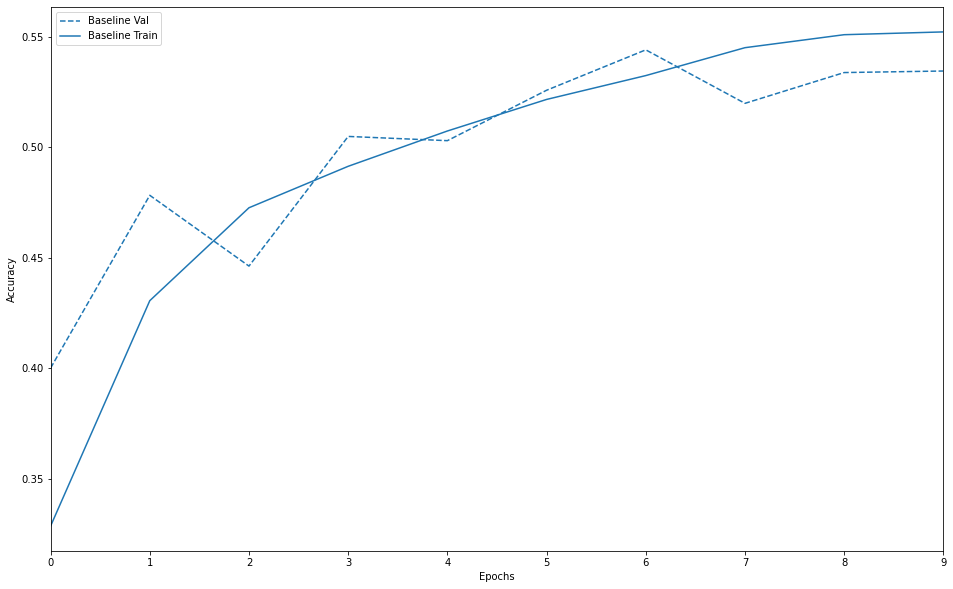

In [11]:
plot_history([('baseline', base_history)], 'accuracy')

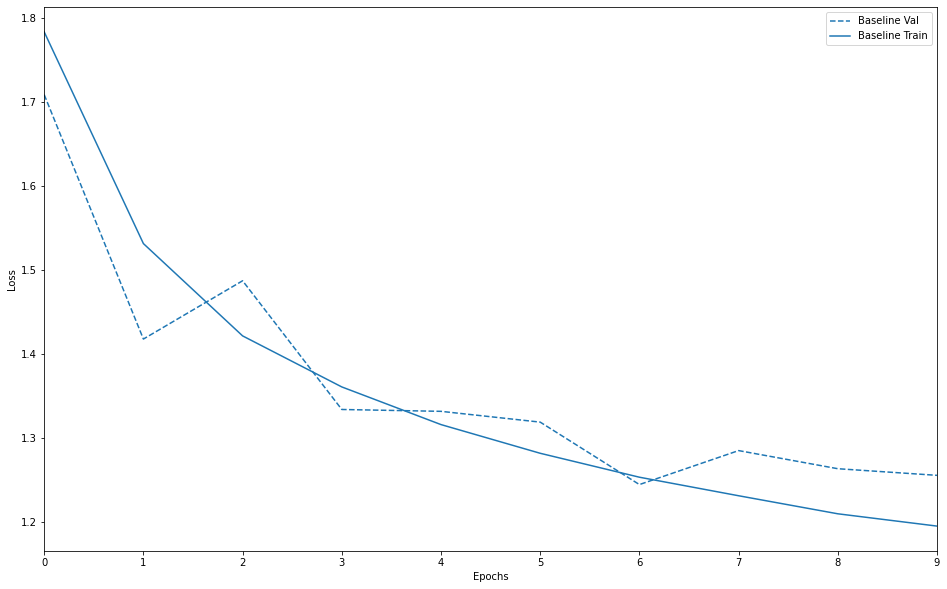

In [12]:
plot_history([('baseline', base_history)], 'loss')

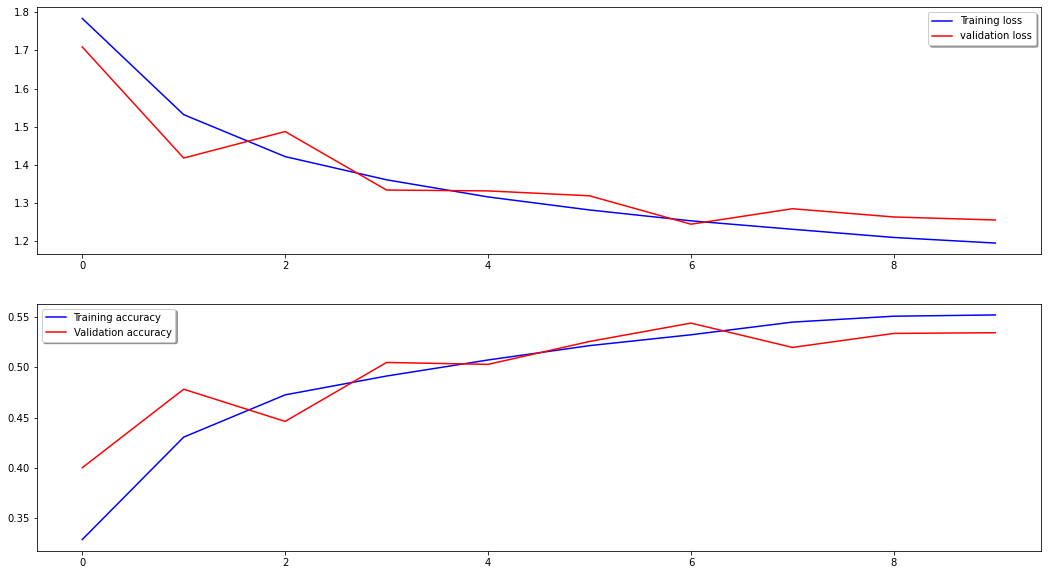

In [16]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(base_history.history['loss'], color='b', label="Training loss")
ax[0].plot(base_history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(base_history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(base_history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Confusion Matrix and Classification on training set

In [23]:
ytest

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)

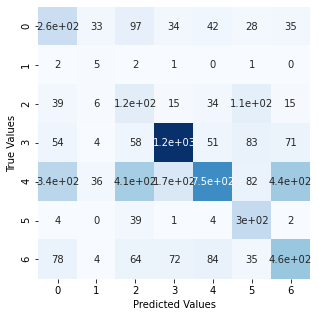

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
model = load_model('model_best_0_1.h5')
fig = plt.figure(figsize=(5, 5))

y_test = []
for e in ytest:
    for i in range(len(e)):
        if e[i]==1:
            y_test.append(i)
            break

y_pred = model.predict(xtest) 
y_pred = np.argmax(y_pred, axis=1)
mat = confusion_matrix(y_test, y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');
plt.show();

Confusion Matrix
[[1230    6  134  226 1301   18  303]
 [  95   25   26   16  168    4   14]
 [ 317    8  656  246 1657  168  247]
 [ 131    2   60 4658  625   22  254]
 [ 193    1   77  190 3010    6  386]
 [ 103    0  390  308  333 1244  160]
 [ 134    1   58  283 1612    9 1852]]
Classification Report
              precision    recall  f1-score   support

       angry       0.56      0.38      0.45      3218
     disgust       0.58      0.07      0.13       348
      scared       0.47      0.20      0.28      3299
       happy       0.79      0.81      0.80      5752
         sad       0.35      0.78      0.48      3863
   surprised       0.85      0.49      0.62      2538
     neutral       0.58      0.47      0.52      3949

    accuracy                           0.55     22967
   macro avg       0.59      0.46      0.47     22967
weighted avg       0.60      0.55      0.54     22967



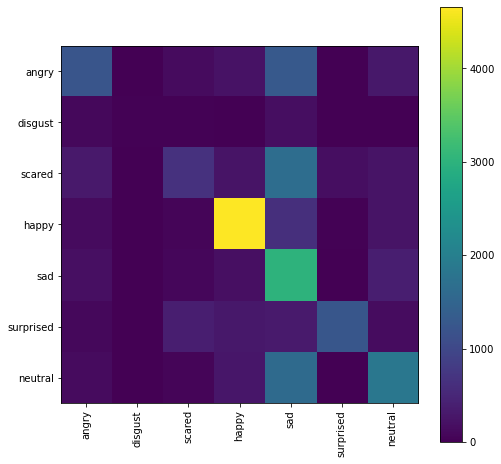

In [30]:
y_pred = model.predict(xtrain)
y_pred = np.argmax(y_pred, axis=1)

# class_labels = training_set.class_indices
# class_labels = {v:k for k,v in class_labels.items()}

EMOTIONS = ["angry","disgust","scared", "happy", "sad", "surprised","neutral"]


y_train = []
for e in ytrain:
    for i in range(len(e)):
        if e[i]==1:
            y_train.append(i)
            break


from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(y_train, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = EMOTIONS
print(classification_report(y_train, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

Confusion Matrix and Classification on test set

Confusion Matrix
[[ 262    2   39   54  338    4   78]
 [  33    5    6    4   36    0    4]
 [  97    2  125   58  413   39   64]
 [  34    1   15 1170  170    1   72]
 [  42    0   34   51  752    4   84]
 [  28    1  106   83   82  298   35]
 [  35    0   15   71  436    2  457]]
Classification Report


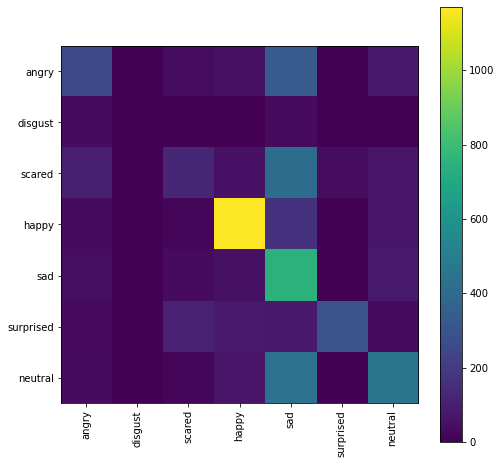

In [32]:
y_pred = model.predict(xtest)
y_pred = np.argmax(y_pred, axis=1)
# class_labels = test_set.class_indices
# class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(y_test, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = EMOTIONS
# print(classification_report(y_test, y_pred, target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

# 단일 사진 결과 확인

In [14]:
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import cv2
import numpy as np
import sys
import time
#from google.colab.patches import cv2_imshow
 
# parameters for loading data and images
detection_model_path = 'haarcascade_files/haarcascade_frontalface_default.xml'
emotion_model_path = 'model_best_0_1.h5'
img_path =  "ggg.jpg" # sys.argv[1]
 
# hyper-parameters for bounding boxes shape
# loading models
face_detection = cv2.CascadeClassifier(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
EMOTIONS = ["angry","disgust","scared", "happy", "sad", "surprised","neutral"]
 
#reading the frame
orig_frame = cv2.imread(img_path)
#print(img_path)
#print(orig_frame)
frame = cv2.imread(img_path,0)
#print(frame)
faces = face_detection.detectMultiScale(frame,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)
 
if len(faces) > 0:
    print(faces)
    faces = sorted(faces, reverse=True,key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
    (fX, fY, fW, fH) = faces
    print(fX)
    roi = frame[fY:fY + fH, fX:fX + fW]
    roi = cv2.resize(roi, (48, 48))
    roi = roi.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    preds = emotion_classifier.predict(roi)[0]
    emotion_probability = np.max(preds)
    label = EMOTIONS[preds.argmax()]
    cv2.putText(orig_frame, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    cv2.rectangle(orig_frame, (fX, fY), (fX + fW, fY + fH),(0, 0, 255), 2)
 
cv2.imshow('test_face', orig_frame)
#cv2_imshow(orig_frame)
cv2.imwrite('test_output/'+img_path.split('/')[-1],orig_frame)
if (cv2.waitKey(0) and 0xFF == ord('q')):
    sys.exit("Thanks")
cv2.destroyAllWindows()

[[390 293 599 599]]
390


# 실시간 영상을 통한 결과 확인

In [49]:
from statistics import mode

import cv2
from keras.models import load_model
import numpy as np

from utils.datasets import get_labels
from utils.inference import detect_faces
from utils.inference import draw_text
from utils.inference import draw_bounding_box
from utils.inference import apply_offsets
from utils.inference import load_detection_model
from utils.preprocessor import preprocess_input

# parameters for loading data and images
detection_model_path = 'haarcascade_files/haarcascade_frontalface_default.xml'
emotion_model_path = 'model_best_0_1.h5'
emotion_labels = get_labels('fer2013')

# hyper-parameters for bounding boxes shape
frame_window = 10
emotion_offsets = (20, 40)

# loading models
face_detection = load_detection_model(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)

# getting input model shapes for inference
emotion_target_size = emotion_classifier.input_shape[1:3]

# starting lists for calculating modes
emotion_window = []

In [47]:
emotion_labels

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'sad',
 5: 'surprise',
 6: 'neutral'}

In [48]:
from keras.preprocessing.image import img_to_array

# starting video streaming
cv2.namedWindow('window_frame')
video_capture = cv2.VideoCapture(0)
while True:
    bgr_image = video_capture.read()[1]
    gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    faces = detect_faces(face_detection, gray_image)
    
    for face_coordinates in faces:

        x1, x2, y1, y2 = apply_offsets(face_coordinates, emotion_offsets)
        gray_face = gray_image[y1:y2, x1:x2]
        try:
            gray_face = cv2.resize(gray_face, (emotion_target_size))
        except:
            continue

        gray_face = preprocess_input(gray_face, True)
        gray_face = np.expand_dims(gray_face, 0)
        gray_face = np.expand_dims(gray_face, -1)
        emotion_prediction = emotion_classifier.predict(gray_face)
        emotion_probability = np.max(emotion_prediction)
        emotion_label_arg = np.argmax(emotion_prediction)
        emotion_text = emotion_labels[emotion_label_arg]
        emotion_window.append(emotion_text)

        if len(emotion_window) > frame_window:
            emotion_window.pop(0)
        try:
            emotion_mode = mode(emotion_window)
        except:
            continue

        if emotion_text == 'angry':
            color = emotion_probability * np.asarray((255, 0, 0))
        elif emotion_text == 'sad':
            color = emotion_probability * np.asarray((0, 0, 255))
        elif emotion_text == 'happy':
            color = emotion_probability * np.asarray((255, 255, 0))
        elif emotion_text == 'surprise':
            color = emotion_probability * np.asarray((0, 255, 255))
        else:
            color = emotion_probability * np.asarray((0, 255, 0))

        color = color.astype(int)
        color = color.tolist()

        draw_bounding_box(face_coordinates, rgb_image, color)
        draw_text(face_coordinates, rgb_image, emotion_mode,
                  color, 0, -45, 1, 1)
        draw_text(face_coordinates, rgb_image, str(emotion_labels[0])+' : '+str(round(emotion_prediction[0][0],2)),
                  [0, 99, 99], 250, 10, 1, 1)
        draw_text(face_coordinates, rgb_image, str(emotion_labels[1])+' : '+str(round(emotion_prediction[0][1],2)),
                  [99, 0, 99], 250, 60, 1, 1)
        draw_text(face_coordinates, rgb_image, str(emotion_labels[2])+' : '+str(round(emotion_prediction[0][2],2)),
                  [0, 99, 0], 250, 110, 1, 1)
        draw_text(face_coordinates, rgb_image, str(emotion_labels[3])+' : '+str(round(emotion_prediction[0][3],2)),
                  [0, 0, 0], 250, 160, 1, 1)
        
        
        
    bgr_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
    cv2.imshow('window_frame', bgr_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()

In [5]:
emotion_mode

'angry'

In [6]:
color

[0, 99, 0]

In [7]:
emotion_probability

0.26536554

In [10]:
round(emotion_prediction[0][0],2)

0.24